# Word2Vec Gender Bias Analysis

This notebook analyzes gender bias in Word2Vec embeddings using:
1. **Intrinsic Bias**: WEAT (Word Embedding Association Test) for gender-career stereotypes
2. **Sentiment Analysis**: Gender bias in sentiment predictions on SST-2 dataset

## Research Questions:
- Do Word2Vec embeddings associate male names more with career words?
- Do sentiment predictions show systematic bias against any gender?

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import spatial, stats
from gensim.models import Word2Vec
import gensim.downloader as api
from sklearn.metrics import accuracy_score, f1_score
from datasets import load_dataset
import warnings
warnings.filterwarnings('ignore')

# Set plot style
plt.style.use('default')
sns.set_palette("husl")

In [16]:
# Global variables for the analysis
MODEL = None  # Will store our Word2Vec model
WEAT_WORDLISTS = {
    'gender_career': {
        # MALE NAMES (20 names instead of 8)
        'target_1': [
            'james', 'john', 'robert', 'michael', 'william', 'david', 'richard', 'joseph',
            'thomas', 'christopher', 'charles', 'daniel', 'matthew', 'anthony', 'mark', 'donald',
            'steven', 'paul', 'andrew', 'joshua'
        ],
        
        # FEMALE NAMES (20 names instead of 8) 
        'target_2': [
            'mary', 'patricia', 'jennifer', 'linda', 'elizabeth', 'barbara', 'susan', 'jessica',
            'sarah', 'karen', 'nancy', 'lisa', 'betty', 'helen', 'sandra', 'donna',
            'carol', 'ruth', 'sharon', 'michelle'
        ],
        
        # CAREER WORDS (15 words instead of 6)
        'attribute_1': [
            'career', 'corporation', 'salary', 'office', 'business', 'professional',
            'executive', 'management', 'leadership', 'entrepreneur', 'workplace', 'industry',
            'employment', 'promotion', 'achievement'
        ],
        
        # FAMILY WORDS (15 words instead of 6)
        'attribute_2': [
            'home', 'family', 'children', 'parents', 'marriage', 'wedding',
            'domestic', 'household', 'nurturing', 'caring', 'relatives', 'siblings',
            'motherhood', 'parenting', 'kinship'
        ]
    }
}

In [17]:
def load_word2vec_model(model_name='word2vec-google-news-300'):
    """
    Load pre-trained Word2Vec model from Gensim
    
    Args:
        model_name (str): Name of the pre-trained model
    
    Returns:
        Loaded Word2Vec model
    """
    global MODEL
    
    try:
        print(f"Loading pre-trained model: {model_name}")
        print("This may take a few minutes for first-time download...")
        MODEL = api.load(model_name)
        print(f"Successfully loaded {model_name}!")
        print(f"Vocabulary size: {len(MODEL.key_to_index):,} words")
        return MODEL
    except Exception as e:
        print(f"Error loading model: {e}")
        return None

# Load the model
model = load_word2vec_model()

Loading pre-trained model: word2vec-google-news-300
This may take a few minutes for first-time download...
Successfully loaded word2vec-google-news-300!
Vocabulary size: 3,000,000 words


In [18]:
def get_embedding(word, model=None):
    """Get word embedding from the model"""
    if model is None:
        model = MODEL
    
    try:
        if hasattr(model, 'wv'):
            return model.wv[word]
        else:
            return model[word]
    except KeyError:
        return None

def cosine_similarity(vec1, vec2):
    """Calculate cosine similarity between two vectors"""
    return 1 - spatial.distance.cosine(vec1, vec2)

def explore_embeddings():
    """Explore basic properties of embeddings"""
    print("🔍 EMBEDDING EXPLORATION")
    print("=" * 40)
    
    # Test some words
    test_words = ['man', 'woman', 'career', 'family', 'john', 'mary']
    available_words = []
    
    for word in test_words:
        embedding = get_embedding(word)
        if embedding is not None:
            available_words.append(word)
            print(f"✅ '{word}': shape {embedding.shape}")
        else:
            print(f"❌ '{word}': not found in vocabulary")
    
    print(f"\nAvailable words for analysis: {available_words}")
    
    # Show some similarities
    if len(available_words) >= 4:
        print(f"\n📊 Sample similarities:")
        word_pairs = [('man', 'career'), ('woman', 'family'), ('man', 'family'), ('woman', 'career')]
        
        for w1, w2 in word_pairs:
            emb1, emb2 = get_embedding(w1), get_embedding(w2)
            if emb1 is not None and emb2 is not None:
                sim = cosine_similarity(emb1, emb2)
                print(f"  {w1} ↔ {w2}: {sim:.3f}")

# Run exploration
explore_embeddings()

🔍 EMBEDDING EXPLORATION
✅ 'man': shape (300,)
✅ 'woman': shape (300,)
✅ 'career': shape (300,)
✅ 'family': shape (300,)
✅ 'john': shape (300,)
✅ 'mary': shape (300,)

Available words for analysis: ['man', 'woman', 'career', 'family', 'john', 'mary']

📊 Sample similarities:
  man ↔ career: 0.152
  woman ↔ family: 0.264
  man ↔ family: 0.212
  woman ↔ career: 0.090


In [19]:
def weat_test_with_stats(target_1, target_2, attribute_1, attribute_2):
    """
    Perform WEAT test with detailed statistics for bias proof
    
    Args:
        target_1: List of target words (e.g., male names)
        target_2: List of target words (e.g., female names)  
        attribute_1: List of attribute words (e.g., career words)
        attribute_2: List of attribute words (e.g., family words)
    
    Returns:
        Dictionary with effect size, p-value, and detailed statistics
    """
    def get_similarities(targets, attributes):
        similarities = []
        target_attr_pairs = []
        
        for target in targets:
            target_vec = get_embedding(target)
            if target_vec is None:
                continue
                
            for attr in attributes:
                attr_vec = get_embedding(attr)
                if attr_vec is not None:
                    sim = cosine_similarity(target_vec, attr_vec)
                    similarities.append(sim)
                    target_attr_pairs.append((target, attr, sim))
        
        return similarities, target_attr_pairs
    
    # Calculate all similarities
    print("🧮 Calculating similarities...")
    s1_sims, s1_pairs = get_similarities(target_1, attribute_1)  # Male + Career
    s2_sims, s2_pairs = get_similarities(target_1, attribute_2)  # Male + Family  
    s3_sims, s3_pairs = get_similarities(target_2, attribute_1)  # Female + Career
    s4_sims, s4_pairs = get_similarities(target_2, attribute_2)  # Female + Family
    
    # Calculate means
    s1_mean = np.mean(s1_sims) if s1_sims else 0
    s2_mean = np.mean(s2_sims) if s2_sims else 0
    s3_mean = np.mean(s3_sims) if s3_sims else 0
    s4_mean = np.mean(s4_sims) if s4_sims else 0
    
    # WEAT effect size
    effect_size = (s1_mean - s2_mean) - (s3_mean - s4_mean)
    
    # Statistical significance test
    all_target1_diffs = [s1 - s2 for s1, s2 in zip(s1_sims[:len(s2_sims)], s2_sims[:len(s1_sims)])]
    all_target2_diffs = [s3 - s4 for s3, s4 in zip(s3_sims[:len(s4_sims)], s4_sims[:len(s3_sims)])]
    
    if all_target1_diffs and all_target2_diffs:
        t_stat, p_value = stats.ttest_ind(all_target1_diffs, all_target2_diffs)
    else:
        t_stat, p_value = 0, 1.0
    
    return {
        'effect_size': effect_size,
        'p_value': p_value,
        't_statistic': t_stat,
        'similarities': {
            'male_career': s1_sims,
            'male_family': s2_sims, 
            'female_career': s3_sims,
            'female_family': s4_sims
        },
        'means': {
            'male_career': s1_mean,
            'male_family': s2_mean,
            'female_career': s3_mean, 
            'female_family': s4_mean
        },
        'sample_sizes': {
            'male_career': len(s1_sims),
            'male_family': len(s2_sims),
            'female_career': len(s3_sims),
            'female_family': len(s4_sims)
        }
    }

def run_weat_analysis():
    """Run WEAT analysis on gender-career associations"""
    print("🎯 WEAT ANALYSIS: Gender-Career Stereotypes")
    print("=" * 50)
    
    wordlists = WEAT_WORDLISTS['gender_career']
    
    print("📝 Test Setup:")
    print(f"  Male names: {wordlists['target_1']}")
    print(f"  Female names: {wordlists['target_2']}")
    print(f"  Career words: {wordlists['attribute_1']}")
    print(f"  Family words: {wordlists['attribute_2']}")
    print()
    
    # Run WEAT test
    results = weat_test_with_stats(
        wordlists['target_1'], wordlists['target_2'],
        wordlists['attribute_1'], wordlists['attribute_2']
    )
    
    # Display results
    effect_size = results['effect_size']
    p_value = results['p_value']
    
    print("📊 RESULTS:")
    print(f"  Effect Size: {effect_size:.4f}")
    print(f"  P-value: {p_value:.4f}")
    
    # Interpretation
    significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "ns"
    bias_level = "Large" if abs(effect_size) > 0.8 else "Medium" if abs(effect_size) > 0.5 else "Small" if abs(effect_size) > 0.2 else "Minimal"
    
    print(f"  Significance: {significance}")
    print(f"  Bias Level: {bias_level}")
    
    print(f"\n💡 INTERPRETATION:")
    if effect_size > 0:
        print(f"  Male names are more associated with career words than female names")
        print(f"  This suggests gender-career stereotypes in the embeddings")
    else:
        print(f"  Female names are more associated with career words than male names")
        print(f"  This suggests reverse stereotyping or balanced associations")
    
    # Show detailed means
    print(f"\n📈 Association Strengths:")
    means = results['means']
    for category, mean_val in means.items():
        print(f"  {category.replace('_', ' ').title()}: {mean_val:.4f}")
    
    return results

# Run WEAT analysis
weat_results = run_weat_analysis()

🎯 WEAT ANALYSIS: Gender-Career Stereotypes
📝 Test Setup:
  Male names: ['james', 'john', 'robert', 'michael', 'william', 'david', 'richard', 'joseph', 'thomas', 'christopher', 'charles', 'daniel', 'matthew', 'anthony', 'mark', 'donald', 'steven', 'paul', 'andrew', 'joshua']
  Female names: ['mary', 'patricia', 'jennifer', 'linda', 'elizabeth', 'barbara', 'susan', 'jessica', 'sarah', 'karen', 'nancy', 'lisa', 'betty', 'helen', 'sandra', 'donna', 'carol', 'ruth', 'sharon', 'michelle']
  Career words: ['career', 'corporation', 'salary', 'office', 'business', 'professional', 'executive', 'management', 'leadership', 'entrepreneur', 'workplace', 'industry', 'employment', 'promotion', 'achievement']
  Family words: ['home', 'family', 'children', 'parents', 'marriage', 'wedding', 'domestic', 'household', 'nurturing', 'caring', 'relatives', 'siblings', 'motherhood', 'parenting', 'kinship']

🧮 Calculating similarities...
📊 RESULTS:
  Effect Size: 0.0564
  P-value: 0.0000
  Significance: ***
  Bi

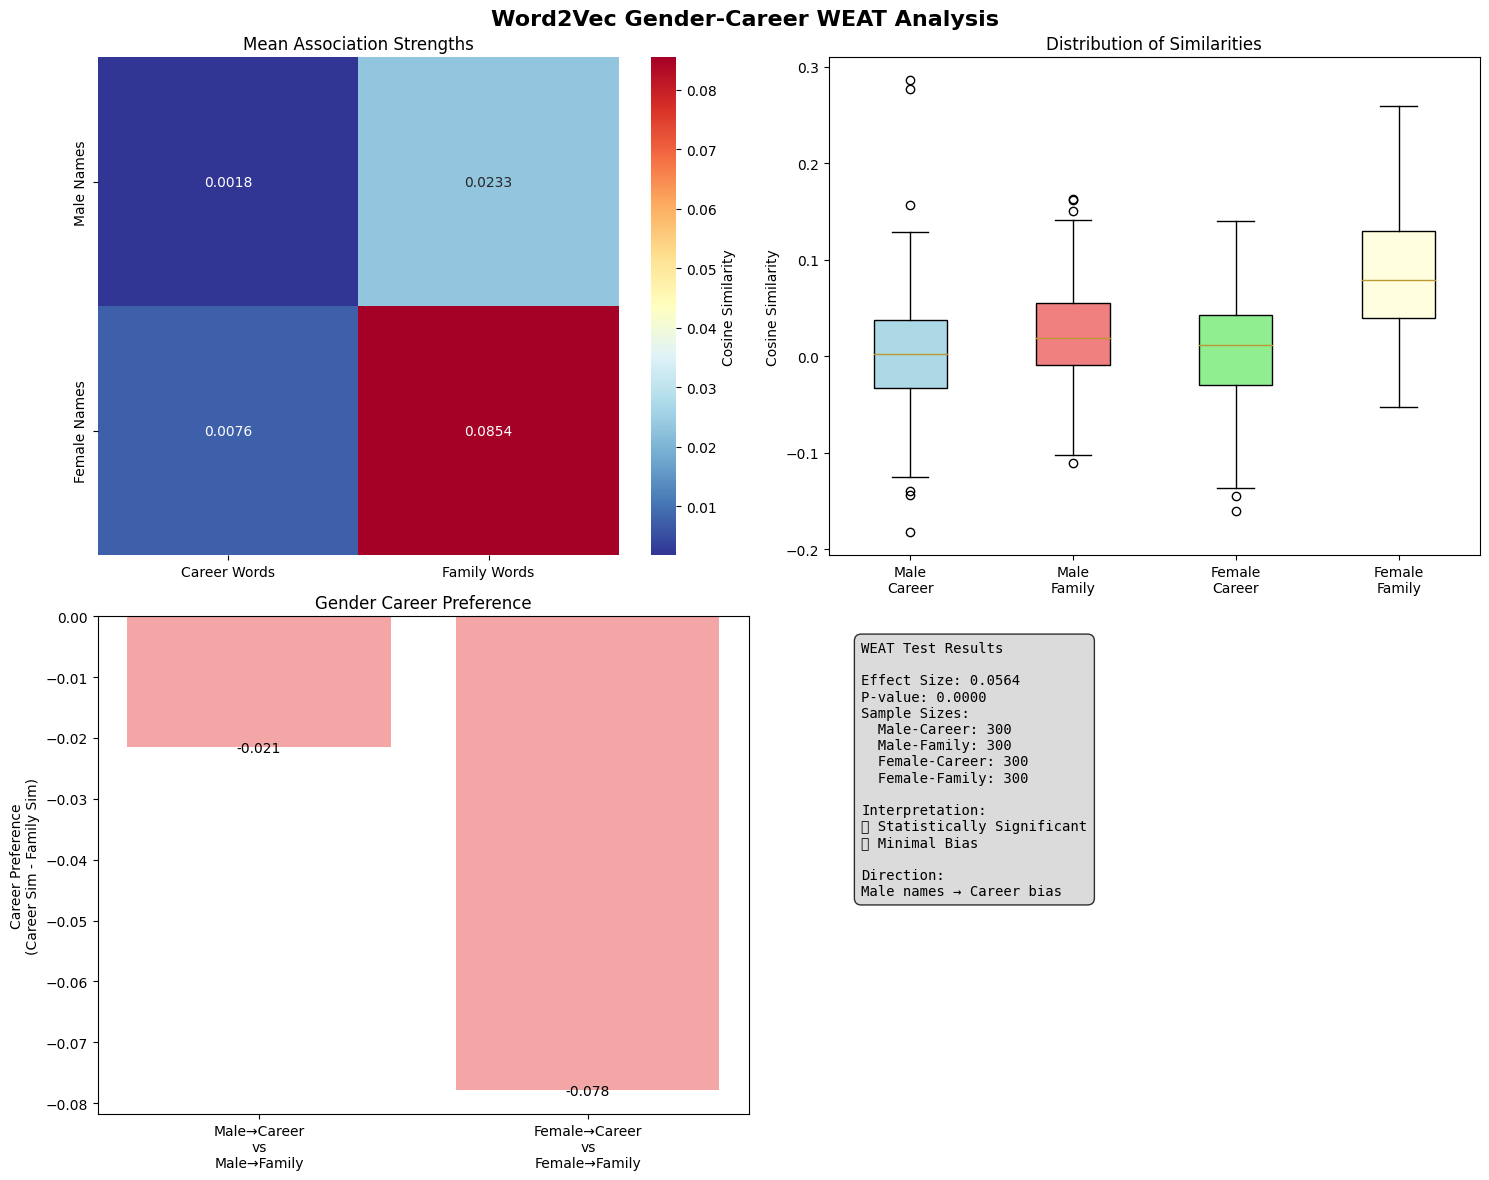

📁 Visualization saved as 'weat_gender_career_analysis.png'


In [20]:
# %% [markdown]
# ## Step 4: Visualize WEAT Results

# %%
def create_weat_visualizations(weat_results):
    """Create comprehensive visualizations for WEAT results"""
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Word2Vec Gender-Career WEAT Analysis', fontsize=16, fontweight='bold')
    
    # 1. Heatmap of mean associations
    if 'means' in weat_results:
        means = weat_results['means']
        heatmap_data = np.array([
            [means['male_career'], means['male_family']],
            [means['female_career'], means['female_family']]
        ])
        
        sns.heatmap(heatmap_data, 
                   xticklabels=['Career Words', 'Family Words'],
                   yticklabels=['Male Names', 'Female Names'],
                   annot=True, fmt='.4f', cmap='RdYlBu_r',
                   ax=axes[0,0], cbar_kws={'label': 'Cosine Similarity'})
        axes[0,0].set_title('Mean Association Strengths')
    
    # 2. Box plot of similarity distributions
    if 'similarities' in weat_results:
        sims = weat_results['similarities']
        data_to_plot = []
        labels = []
        
        for key, values in sims.items():
            if values:
                data_to_plot.append(values)
                labels.append(key.replace('_', '\n').title())
        
        if data_to_plot:
            box_plot = axes[0,1].boxplot(data_to_plot, labels=labels, patch_artist=True)
            colors = ['lightblue', 'lightcoral', 'lightgreen', 'lightyellow']
            for patch, color in zip(box_plot['boxes'], colors[:len(box_plot['boxes'])]):
                patch.set_facecolor(color)
            
            axes[0,1].set_ylabel('Cosine Similarity')
            axes[0,1].set_title('Distribution of Similarities')
            axes[0,1].tick_params(axis='x', rotation=0)
    
    # 3. Effect size visualization
    effect_size = weat_results['effect_size']
    p_value = weat_results['p_value']
    
    # Bar chart showing the effect
    categories = ['Male→Career\nvs\nMale→Family', 'Female→Career\nvs\nFemale→Family']
    if 'means' in weat_results:
        means = weat_results['means']
        values = [
            means['male_career'] - means['male_family'],
            means['female_career'] - means['female_family']
        ]
        
        colors = ['lightblue' if v > 0 else 'lightcoral' for v in values]
        bars = axes[1,0].bar(categories, values, color=colors, alpha=0.7)
        axes[1,0].set_ylabel('Career Preference\n(Career Sim - Family Sim)')
        axes[1,0].set_title('Gender Career Preference')
        axes[1,0].axhline(y=0, color='black', linestyle='-', alpha=0.3)
        
        # Add value labels
        for bar, val in zip(bars, values):
            height = bar.get_height()
            axes[1,0].text(bar.get_x() + bar.get_width()/2, height + 0.001,
                          f'{val:.3f}', ha='center', va='bottom' if height > 0 else 'top')
    
    # 4. Statistical summary
    summary_text = f"""
WEAT Test Results

Effect Size: {effect_size:.4f}
P-value: {p_value:.4f}
Sample Sizes:
  Male-Career: {weat_results.get('sample_sizes', {}).get('male_career', 0)}
  Male-Family: {weat_results.get('sample_sizes', {}).get('male_family', 0)}
  Female-Career: {weat_results.get('sample_sizes', {}).get('female_career', 0)}
  Female-Family: {weat_results.get('sample_sizes', {}).get('female_family', 0)}

Interpretation:
{"✅ Statistically Significant" if p_value < 0.05 else "❌ Not Significant"}
{"🔴 Strong Bias" if abs(effect_size) > 0.5 else "🟡 Moderate Bias" if abs(effect_size) > 0.2 else "🟢 Minimal Bias"}

Direction:
{"Male names → Career bias" if effect_size > 0 else "Female names → Career bias" if effect_size < 0 else "No clear bias"}
    """
    
    axes[1,1].text(0.05, 0.95, summary_text.strip(), transform=axes[1,1].transAxes,
                  fontsize=10, verticalalignment='top', fontfamily='monospace',
                  bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgray", alpha=0.8))
    axes[1,1].set_xlim(0, 1)
    axes[1,1].set_ylim(0, 1)
    axes[1,1].axis('off')
    
    plt.tight_layout()
    plt.savefig('weat_gender_career_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("📁 Visualization saved as 'weat_gender_career_analysis.png'")

# Create WEAT visualizations
create_weat_visualizations(weat_results)